In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, MaxAbsScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

df = pd.read_csv('../Time Series Data/time_series_covid_19_confirmed_US.csv')
df.dropna(inplace = True)
x = np.arange('2020-01-22', '2020-04-21', dtype = 'datetime64[D]')
#df['Country/Region Code'] = df['Country/Region'].astype('category').cat.codes.values
#df['Province/State Code'] =  df['Province/State'].astype('category').cat.codes.values
a = df.drop(['UID', 'iso3', 'iso2', 'code3', 'FIPS', 'Admin2', 'Province_State','Country_Region','Lat','Long_', 'Combined_Key'], axis = 1, inplace  = False)
df2 = pd.DataFrame()
for i,name in enumerate(df['Combined_Key']):
    df2[name] = a.iloc[i]
df2

In [2]:
def plotGraph(name):
    plt.figure(figsize = (12,10))
    plt.title(name)
    plt.plot(df2[name])
    plt.autoscale(axis='x',tight=True)
    plt.xlim(('3/13/20','4/2/20'))

def test_train(name,test_size,num):
    m = df2[name].values.astype(float)
    train_set = m[num:-test_size]
    test_set = m[-test_size:]
    return train_set, test_set

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out


    scaler = PowerTransformer(method='box-cox', standardize=False)
    x_norm2 = scaler.fit_transform(train_set.reshape(-1,1))
    train_norms = torch.FloatTensor(x_norm2).view(-1)
    

def training(epoch, train_data, losses):
    for i in range(epoch):
        for seq,y_train in train_data:
            optimizer.zero_grad()
            model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
            y_pred = model(seq)
            loss = torch.sqrt(criterion(y_pred, y_train))
            loss.backward()
            optimizer.step()
        print(f'epoch: {i} loss: {loss.item()}')
        losses.append(loss.item())

50

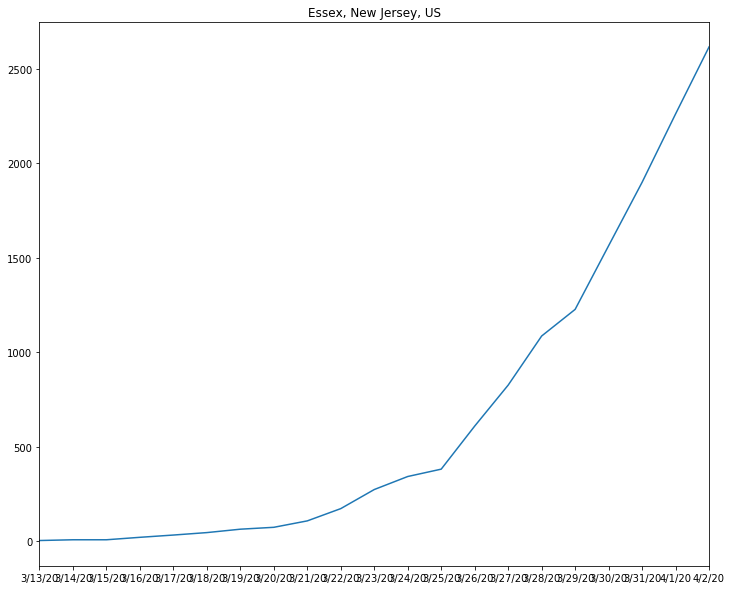

In [3]:
plotGraph('Essex, New Jersey, US')
x = []
y = 50
for num in df2['Essex, New Jersey, US']:
    if(num == 0):
        x.append(num)
if(len(x)>=50):
    y = len(x)
train_set,test_set = test_train('Essex, New Jersey, US',7,y)
len(x)


In [4]:
class LSTMcell(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 1650, output_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1,1,self.hidden_size).cuda(), torch.zeros(1,1,self.hidden_size))
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [5]:
torch.manual_seed(60)
model = LSTMcell()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
model

LSTMcell(
  (lstm): LSTM(1, 1650)
  (linear): Linear(in_features=1650, out_features=1, bias=True)
)

In [6]:
scaler = StandardScaler()
x_norm2 = scaler.fit_transform(train_set.reshape(-1,1))
train_norms = torch.FloatTensor(x_norm2).view(-1)

In [7]:
model.load_state_dict(torch.load('../Extra Data/Essex'))
model.eval()

LSTMcell(
  (lstm): LSTM(1, 1650)
  (linear): Linear(in_features=1650, out_features=1, bias=True)
)

In [8]:
window_size = 7
future = 7
pred = train_norms[-window_size:].tolist()
for i in range(future):
    with torch.no_grad():
        seq = torch.FloatTensor(pred[-window_size:])
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        pred.append(model(seq).item())

In [9]:
pred[-7:]

[3.791309118270874,
 5.492214202880859,
 7.451582908630371,
 9.305092811584473,
 10.801518440246582,
 12.17676067352295,
 13.438097953796387]

In [10]:
z = scaler.inverse_transform(np.array(pred).reshape(-1,1))

In [11]:
z

array([[  72.99999747],
       [ 107.00000026],
       [ 171.9999997 ],
       [ 273.00000256],
       [ 342.00000585],
       [ 380.99999458],
       [ 609.0000136 ],
       [ 804.48691503],
       [1101.55063596],
       [1443.75512678],
       [1767.47133737],
       [2028.82264344],
       [2269.00922334],
       [2489.30225981]])

(array([61.]), array([71.]))

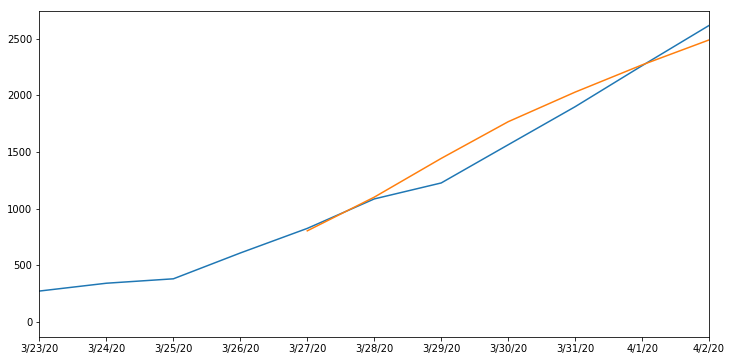

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df2['Essex, New Jersey, US'])
plt.plot(['3/27/20','3/28/20','3/29/20','3/30/20','3/31/20','4/1/20','4/2/20'],z[-7:])
plt.xlim(('3/23/20','4/2/20'))

In [13]:
all_data_norm = scaler.fit_transform(df2['Essex, New Jersey, US'].values.astype('float64').reshape(-1,1))
all_data_norm = torch.FloatTensor(all_data_norm).view(-1)
all_data = input_data(all_data_norm,7)

In [14]:
epochs = 1
losses = []

for i in range(epochs):
    for seq, y_train in all_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = (criterion(y_pred, y_train))
        loss.backward()
        optimizer.step()
    print(f'epoch: {i} loss: {loss.item()}')
    losses.append(loss.item())

epoch: 0 loss: 0.3002045452594757


In [15]:
pred = all_data_norm[-7:].tolist()
for i in range(future):
    with torch.no_grad():
        seq = torch.FloatTensor(pred[-7:])
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        pred.append(model(seq).item())
        

In [16]:
pred[-7:]

[5.573267936706543,
 6.522406578063965,
 7.382699966430664,
 8.271406173706055,
 9.016265869140625,
 9.641725540161133,
 10.15676498413086]

In [17]:
z = scaler.inverse_transform(np.array(pred).reshape(-1,1))

In [18]:
z

array([[ 825.99998576],
       [1085.99999319],
       [1226.99999745],
       [1563.99997767],
       [1899.99997196],
       [2261.99997321],
       [2617.000073  ],
       [3095.09851458],
       [3589.99159791],
       [4038.55962474],
       [4501.94246043],
       [4890.32187653],
       [5216.44458569],
       [5484.99276966]])

(array([61.]), array([78.]))

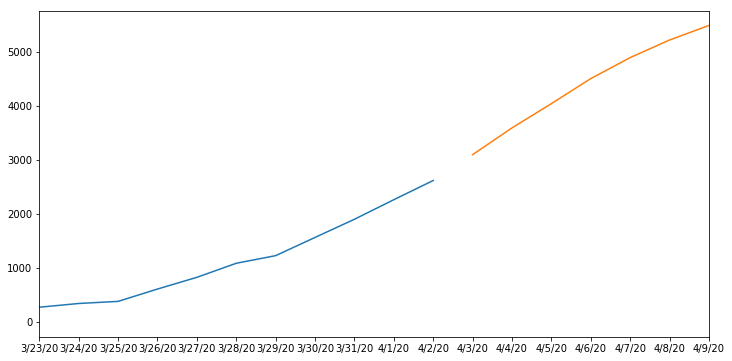

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df2['Essex, New Jersey, US'])
plt.plot(['4/3/20','4/4/20','4/5/20','4/6/20','4/7/20','4/8/20','4/9/20'],z[-7:])
plt.xlim(('3/23/20','4/9/20'))